## 1. Differential equation-based model (Bass model)

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
from functools import partial

In [2]:
def dem(params):
    '''
    differential equation-based model
    '''
    p, q, m, T = params
    t_list = np.arange(1, T + 1)
    a = 1 - np.exp(-(p + q) * t_list)
    b = 1 + q / p * np.exp(-(p + q) * t_list)
    diffu_cont = m * a / b
    adopt_cont = np.array(
        [diffu_cont[i] if i == 0 else diffu_cont[i] - diffu_cont[i - 1] for i in range(T)]
    )
    return adopt_cont

In [3]:
def calcu_mse(params, s):  # mean squared error
    '''
    calculate the mean squared error between the output of dem and empirical data
    '''
    p, q, m = params
    a = dem([p, q, m, len(s)])
    sse = np.sum(np.square(s - a))
    return np.sqrt(sse) / len(s)  # 均方误

In [4]:
def calcu_r2(estimates, s):
    '''
    calculate the r2 for the fit
    '''
    s_hat = dem(params=(*estimates, len(s)))
    tse = np.sum(np.square(s - s_hat))
    mean_y = np.mean(s)
    ssl = np.sum(np.square(s - mean_y))
    R_2 = (ssl - tse) / ssl
    return round(R_2, 5)

In [5]:
def fit_dem(s):
    '''
    fit empirical data with dem
    '''
    mse = partial(calcu_mse, s=s)  # fix the s
    candidate_sols = []
    for i in range(10):  # repeate the estimation to increate the probability of getting the optimal estimates
        p0, q0, m0 = 0.01 * np.random.rand(), 0.4 * np.random.rand(), 2*np.sum(s)  # randomly set the initial values
        try:
            res = minimize(mse, (p0, q0, m0), method='nelder-mead', options={'xatol': 1e-6})
            candidate_sols.append([res.fun, res.x])
        except Exception as e:
            print(e)

    func_value, estimates = sorted(candidate_sols, key=lambda x: x[0])[0]
    r2 = calcu_r2(estimates, s)
    return r2, estimates

In [6]:
data_set = {
    "room air conditioners": (
        np.arange(1949, 1962),
        [96, 195, 238, 380, 1045, 1230, 1267, 1828, 1586, 1673, 1800, 1580, 1500],
    ),
    "color televisions": (np.arange(1963, 1971), [747, 1480, 2646, 5118, 5777, 5982, 5962, 4631]),
    "clothers dryers": (
        np.arange(1949, 1962),
        [106, 319, 492, 635, 737, 890, 1397, 1523, 1294, 1240, 1425, 1260, 1236],
    ),
    "ultrasound": (np.arange(1965, 1979), [5, 3, 2, 5, 7, 12, 6, 16, 16, 28, 28, 21, 13, 6]),
    "mammography": (np.arange(1965, 1979), [2, 2, 2, 3, 4, 9, 7, 16, 23, 24, 15, 6, 5, 1]),
    "foreign language": (
        np.arange(1952, 1964),
        [1.25, 0.77, 0.86, 0.48, 1.34, 3.56, 3.36, 6.24, 5.95, 6.24, 4.89, 0.25],
    ),
    "accelerated program": (
        np.arange(1952, 1964),
        [0.67, 0.48, 2.11, 0.29, 2.59, 2.21, 16.80, 11.04, 14.40, 6.43, 6.15, 1.15],
    ),
}

In [7]:
s = data_set["color televisions"][1]  # empirical data
r2, estimates = fit_dem(s)
print(f"r2: {r2}\nestimates: p={estimates[0]:.5f}, q={estimates[1]:.5f}, m={estimates[2]:.1f},")

r2: 0.9695
estimates: p=0.01847, q=0.61586, m=39658.6,


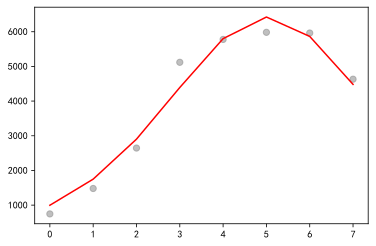

In [8]:
plt.plot(np.arange(len(s)), dem([*estimates, len(s)]), 'r-')
plt.scatter(np.arange(len(s)), s, c='grey', alpha=0.5, s=40)

## 2. Agent-based diffusion model（ABM）

In [9]:
import networkx as nx
import random


class Diffuse:  # 默认网络结构为节点数量为10000，边为30000的随机网络
    def __init__(self, p, q, alpha=0, sigma=0, g=nx.gnm_random_graph(10000, 30000), num_runs=40):
        '''
        p: coefficient of external influence
        q: coefficient of internal influence
        alpha: strength of neighborhood effects
        sigma: individual heterogeneity
        g: network
        num_runs: number of steps for simulation
        '''
        self.g = g.to_directed() if not nx.is_directed(g) else g
        self.nodes_array = np.array(self.g)
        self.num_runs = num_runs
        self.alpha = alpha
        self.sigma = sigma
        for i in self.g:
            self.g.nodes[i]['prede'] = list(self.g.predecessors(i))
            self.g.nodes[i]['num_prede'] = len(self.g.nodes[i]['prede'])
            self.g.nodes[i]['p'] = p*(1 + self.sigma*np.random.randn())
            self.g.nodes[i]['q'] = q*(1 + self.sigma*np.random.randn())
                 
    def decide(self, i):
        '''
        agent i makes innovation decision
        '''
        num_adopt_prede = np.sum([self.g.nodes[k]['state'] for k in self.g.nodes[i]['prede']])
        if self.g.nodes[i]['num_prede']:  # check whether agent i has precedessors or not
            mi = num_adopt_prede/(self.g.nodes[i]['num_prede']**self.alpha)
        else:
            mi = 0
        prob = 1 - (1 - self.g.nodes[i]['p'])*(1 - self.g.nodes[i]['q'])**mi
        return prob > random.random()  # the probability of this inequation takes the value of True is equal to prob

    def update(self, non_node_array):
        '''
        non-adopted agents update states
        '''
        len_nodes = len(non_node_array)  # amount of non-adopted agents
        state_array = np.zeros(len_nodes, dtype=bool)
        for i in range(len_nodes):
            node = non_node_array[i]
            if self.decide(node):
                self.g.nodes[node]['state'] = True  # update node's state
                state_array[i] = True
        return np.sum(state_array), non_node_array[state_array == False]

    def single_diffuse(self):
        '''
        a single diffusion process
        '''
        for i in self.g:  # initialize the state of agents
            self.g.nodes[i]['state'] = False
        non_node_array = self.nodes_array[:]  # array of non-adopted nodes
        num_of_adopt = []  # number of adopters for each step
        for i in range(self.num_runs):
            num, non_node_array = self.update(non_node_array)
            num_of_adopt.append(num)

        return num_of_adopt

    def repete_diffuse(self, repetes=10):
        '''
        perform multiple diffusion processes for a parameter configuration
        '''
        return [self.single_diffuse() for i in range(repetes)]

In [10]:
diffuse = Diffuse(p=0.001, q=0.1)
s_diff = diffuse.single_diffuse()

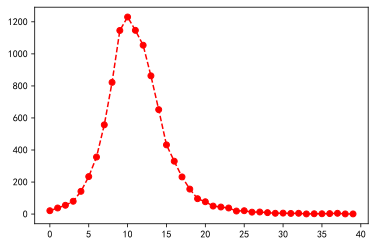

In [11]:
plt.plot(s_diff, 'ro--')

## 3. Generate parameter boundary of ABM

In [13]:
class Gen_para:
    def __init__(self, p_cont=(0.001, 0.02), q_cont=(0.08, 0.1), alpha=0, 
                 sigma=0, g=nx.gnm_random_graph(10000, 30000), delta=(0.0005, 0.01)):
        self.p_cont = p_cont
        self.q_cont = q_cont
        self.d_p, self.d_q = delta
        self.g = g
        self.alpha = alpha
        self.sigma = sigma
        self.num_nodes = self.g.number_of_nodes()

    def add_data(self, p, q):
        diff = Diffuse(p, q, g=self.g, alpha=self.alpha, sigma=self.sigma)
        x = np.mean(diff.repete_diffuse(), axis=0)
        max_idx = np.argmax(x)
        s = x[:(max_idx + 2)]
        _, estimates = fit_dem(s)
        return estimates[:2]  # P, Q

    def identify_range(self):
        min_p, max_p = self.p_cont
        min_q, max_q = self.q_cont
        est_cont = [self.add_data(p, q) for p, q in [(min_p, min_q), (max_p, max_q)]]
        i = 1
        while True:  # P: 0.007~0.03, Q: 0.38~0.53
            min_P, min_Q = est_cont[0]
            max_P, max_Q = est_cont[1]
            print(i, f'P:{min_P:.4f}~{max_P:.4f}', f'Q:{min_Q:.4f}~{max_Q:.4f}' )
            c1, c2 = 0, 0
            # if min_P > the low boundary，then decrease the low boundary of min_p
            if min_P > 0.0007:
                min_p = min_p - self.d_p if min_p > self.d_p else 0.0003
                c1 += 1

            if min_Q > 0.38:  # if min_Q < the low boundary，then decrease the low boundary of min_q
                min_q -= self.d_q
                c1 += 1

            if max_P < 0.03:  # if max_P < the up boundary，then decrease the up boundary of max_p
                max_p += self.d_p
                c2 += 1

            if max_Q < 0.53:  # if max_Q < the up boundary，then increase the up boundary of max_q
                max_q += self.d_q
                c2 += 1

            i += 1

            if c1 + c2 != 0:  # 查看是否进行了更新
                if c1 != 0:  # if min_p或者min_q更新了，则减少
                    est_cont[0] = self.add_data(min_p, min_q)
                if c2 != 0:  # if max_p或者max_q更新了，则增加
                    est_cont[1] = self.add_data(max_p, max_q)
            else:
                break

            if i == 20:
                break

        return {"p_range": [round(min_p, 5), round(max_p, 5)], 
                "q_range": [round(min_q, 5), round(max_q, 5)],
                "P_range": [round(min_P, 5), round(max_P, 5)], 
                "Q_range": [round(min_Q, 5), round(max_Q, 5)]}

    def generate_sample(self, p_range, q_range, n_p=10, n_q=20):
        sp_cont = [(p, q) for p in np.linspace(p_range[0], p_range[1], n_p) 
                        for q in np.linspace(q_range[0], q_range[1], n_q)]
        return sp_cont

In [14]:
gen_para = Gen_para(g=nx.gnm_random_graph(10000, 20000))

In [15]:
t1 = time.perf_counter()
print("======start======")
generated_params_range = gen_para.identify_range()
print(f"Time elapsed {time.perf_counter() - t1:.4f}s")
print("======end======")

======start======
1 P:0.0014~0.0245 Q:0.2434~0.3689
2 P:0.0007~0.0246 Q:0.2498~0.4011
3 P:0.0007~0.0254 Q:0.2498~0.4311
4 P:0.0007~0.0262 Q:0.2498~0.4528
5 P:0.0007~0.0271 Q:0.2498~0.4843
6 P:0.0007~0.0277 Q:0.2498~0.5388
7 P:0.0007~0.0284 Q:0.2498~0.5284
8 P:0.0007~0.0289 Q:0.2498~0.5582
9 P:0.0007~0.0298 Q:0.2498~0.5583
10 P:0.0007~0.0304 Q:0.2498~0.5626


ValueError: Invalid format specifier

In [16]:
p_range, q_range = generated_params_range["p_range"], generated_params_range["q_range"]
parameters = gen_para.generate_sample(p_range, q_range)

In [19]:
p_range, q_range

([0.0005, 0.0245], [0.08, 0.16])

In [ ]:
client = MongoClient('localhost', 27017)
db = client.abmDiffusion
prj = db.sparsity

txt_cont = ['gnm_random_graph(10000,1000)', 'gnm_random_graph(10000,2000)',
    'gnm_random_graph(10000,4000)', 'gnm_random_graph(10000,6000)',
    'gnm_random_graph(10000,8000)', 'gnm_random_graph(10000,10000)', 
    'gnm_random_graph(10000,20000)']

g_cont = [eval('nx.' + g) for g in txt_cont]
bound_dict = {}
for j, g in enumerate(g_cont):
    t1 = time.perf_counter()
    print(j+1, txt_cont[j])
    p_cont = (0.0003, 0.02)  
    q_cont = (0.076*3.0/(j + 4), 0.12*3.0/(j + 4))  # 小心设置
    delta = (0.0001, 0.001)
    ger_samp = Gen_para(g=g, p_cont=p_cont, q_cont=q_cont, delta=delta)
    bound = ger_samp.identify_range()
    prj.insert_one({"_id": txt_cont[j], "param_boundary": bound})
    print(f'  time: {time.perf_counter() - t1:.2f}s')

## 4. Generate diffusion data of ABM

In [ ]:
from pymongo import MongoClient
import datetime
import multiprocessing

def func(p, q, g):
    '''
    p: coefficient of innovativeness
    q: coefficient of imitation
    g: network
    '''
    p = round(p, 5)
    q = round(q, 5)
    diff = Diffuse(p, q, g=g, num_runs=40)
    x = np.mean(diff.repete_diffuse(), axis=0)
    return str([p, q]), list(np.concatenate(([p, q], x)))


if __name__ == '__main__':
    client = MongoClient('localhost', 27017)
    db = client.abmDiffusion
    prj = db.networks

    txt_cont = ['gnm_random_graph(10000,1000)', 'gnm_random_graph(10000,2000)',
        'gnm_random_graph(10000,4000)', 'gnm_random_graph(10000,6000)',
        'gnm_random_graph(10000,8000)', 'gnm_random_graph(10000,10000)', 
        'gnm_random_graph(10000,20000)']

    txt_cont = {x['_id'] for x in prj.find({}, projection={'_id': 1})}
    prj2 = db.abmDatabase  # 新建一个集合
    e_cont = {x['_id'] for x in prj2.find({})}
    txt_cont = list(txt_cont - e_cont)
    print("剩余:", txt_cont)

    for i, key in enumerate(txt_cont):
        print(key)
        print("  开始时间", format(datetime.datetime.now()))
        mongo_date = prj.find_one({"_id": key})
        r_p = mongo_date['param_boundary']['p_range']
        r_q = mongo_date['param_boundary']['q_range']
        pq_cont = [(p, q) for p in np.linspace(r_p[0], r_p[1], num=30)
                          for q in np.linspace(r_q[0], r_q[1], num=50)]

        t1 = time.perf_counter()
        pool = multiprocessing.Pool(processes=5)
        result = []
        for p, q in pq_cont:
            result.append(pool.apply_async(func, (p, q, g)))
        pool.close()
        pool.join()
        data = []
        for res in result:
            data.append(res.get())

        print(i + 1, key, f'Time: {(time.perf_counter() - t1):.2f} s')
        diffuse_curves = dict(data)
        new_curves = {}
        for i, k in enumerate(diffuse_curves):
            new_curves[str(i)] = diffuse_curves[k]

        prj2.insert_one({"_id": key, "diffuse_curves": new_curves})
        print("  结束时间", format(datetime.datetime.now()))

## 5. Fitting diffusion data of ABM with DEM

In [ ]:
from abmdiffuse import Diffuse
from bassestimate import BassEstimate
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import networkx as nx
import time


class estimateABM:
    num_conds = 2  # 构建网格的节点个数

    def __init__(self, s, intv_p=0.0005, intv_q=0.005, G=nx.gnm_random_graph(10000, 30000), m_p=True):
        self.s = s
        self.s_len = len(s)
        self.intv_p = intv_p
        self.intv_q = intv_q
        self.G = G
        self.k = nx.number_of_edges(self.G) / nx.number_of_nodes(self.G)
        self.m_p = m_p  # 传给Diffuse，确定是否多进程

    def __repr__(self):
        return "<G: {0.G!r} s_len={0.s_len} d_p={0.intv_p} d_q={0.intv_q}>".format(self)

    def r2(self, f_act):
        f_act = np.array(f_act)
        tse = np.sum(np.square(self.s - f_act))
        mean_y = np.mean(self.s)
        ssl = np.sum(np.square(self.s - mean_y))
        return (ssl - tse)/ssl

    def get_M(self, p, q):  # 获取对应扩散率曲线的最优潜在市场容量
        if p <= 0:
            raise Exception(f"p={p}小于0!")
        elif q <= 0:
            raise Exception(f"q={q}小于0!")
        else:
            diffu = Diffuse(p, q, g=self.G, num_runs=self.s_len, multi_proc=self.m_p)
            s_estim = diffu.repete_diffuse()
            x = np.mean(s_estim, axis=0)
            a = np.sum(np.square(x)) / np.sum(self.s)  # 除以np.sum(self.s)是为减少a的大小
            b = -2*np.sum(x*self.s) / np.sum(self.s)
            c = np.sum(np.square(self.s)) / np.sum(self.s)
            mse = np.sqrt(sum(self.s) * (4*a*c - b**2) / (4*a*self.s_len))
            sigma = -b/(2*a)
            m = sigma*self.G.number_of_nodes()
            return [mse, p, q, m], list(x*sigma)

    def gener_grid(self, p, q):
        p, q = round(p, 5), round(q, 5)
        temp = {(round(p - self.intv_p, 5) if p > self.intv_p else round(p/2, 5), 
                    round(q - self.intv_q, 5) if q > self.intv_q else round(q/2, 5)),
                (round(p, 5),
                    round(q - self.intv_q, 5) if q > self.intv_q else round(q/2, 5)),
                (round(p + self.intv_p, 5),
                    round(q - self.intv_q, 5) if q > self.intv_q else round(q/2, 5)),
                (round(p - self.intv_p, 5) if p > self.intv_p else round(p/2, 5), 
                    round(q, 5)),
                (round(p, 5), round(q, 5)),
                (round(p + self.intv_p, 5), round(q, 5)),
                (round(p - self.intv_p, 5) if p > self.intv_p else round(p/2, 5), 
                    round(q + self.intv_q, 5)),
                (round(p, 5), round(q + self.intv_q, 5)),
                (round(p + self.intv_p, 5), round(q + self.intv_q, 5))
                }
        return temp

    def gener_init_pq(self):  # 生成初始搜索点(p0,q0)
        rgs = BassEstimate(self.s)
        P0, Q0 = rgs.optima_search()[1 : 3]  # SABM最优点（P0,Q0）
        p_range = np.linspace(0.4*P0, P0, num=3)
        q_range = np.linspace(0.2*Q0/self.k, 0.6*Q0/self.k, num=3)
        to_fit = {}
        params_cont = []
        for p in p_range:  # 取9个点用于确定参数与估计值之间的联系
            for q in q_range:
                diffu = Diffuse(p, q, g=self.G, num_runs=self.s_len, multi_proc=self.m_p)
                s_estim = diffu.repete_diffuse()
                s_estim_avr = np.mean(s_estim, axis=0)
                rgs_1 = BassEstimate(s_estim_avr)
                P, Q = rgs_1.optima_search()[1: 3]
                params_cont.append([p, q, P, Q])

        to_fit = pd.DataFrame(params_cont, columns=['p', 'q', 'P', 'Q'])
        result_p = smf.ols('p~P+Q-1', data=to_fit).fit()
        result_q = smf.ols('q~P+Q-1', data=to_fit).fit()

        p0 = result_p.params['P']*P0 + result_p.params['Q']*Q0
        q0 = result_q.params['P']*P0 + result_q.params['Q']*Q0
        return round(p0, 5), round(q0, 5)   # 保留5位小数位，防止出错

    def solution_search(self, p0, q0):
        solution_list = []
        pq_set = self.gener_grid(p0, q0)
        pq_trace = [pq_set.copy()]  # 初始化(p, q)的搜索轨迹，set().copy()得到新的对象
        for p, q in pq_set:
            try:
                solution = self.get_M(p, q)
                solution_list.append(solution)  # ([mse, p, q, s_M], [扩散曲线])
            except Exception:
                print(f"p:{p}, q:{q}, 不搜索！")

        best_solution = sorted(solution_list)[:self.num_conds]  # 选取num_conds个候选点
        condidate_points = [(z[0][1], z[0][2]) for z in best_solution]
        his_cond = [condidate_points, ]
        i = 0
        while True:
            i += 1
            pq_set2 = set()
            for z in condidate_points:  # 可以取多个作为候选最优解
                temp = self.gener_grid(z[0], z[1])
                pq_set2.update(temp)

            new_points = pq_set2 - pq_set  # 集合减, 未包含在pd_set中的新(p, q)
            print(f"第{i}轮, 新增点个数:{len(new_points)}")
            if len(new_points) == 0:
                break
            else:
                pq_trace.append(new_points)  # 将新增加的点添加到pq_trace中
                for y in new_points:
                    try:
                        solution = self.get_M(y[0], y[1])
                        solution_list.append(solution)
                    except Exception:
                        print(f"p:{p}, q:{q}, 不搜索！")

                best_solution = sorted(solution_list, key=lambda x: x[0][0])[: self.num_conds]
                condidate_points = [(z[0][1], z[0][2]) for z in best_solution]
                his_cond.append(condidate_points)
                opt_solution = best_solution[0]  # [mse, p, q, m], [扩散数据]
                opt_curve = opt_solution[1]  # [扩散数据]
                pq_set.update(new_points)

        R2 = self.r2(opt_curve)
        search_steps = len(pq_set)  # 搜索点的数量
        result = {'params': opt_solution[0][1:],  # 估计值 [p, q, m]
                  'fitness': R2,
                  'best_curve': opt_curve,  # 最优拟合曲线
                  'num_nodes': search_steps,    # 搜索点的数量
                  'path': pq_trace,  # [{(p, q),}, ]的搜索轨迹
                  'his_cond': his_cond,  # 候选点历史
                  'his_data': solution_list}
        return result

## 6. Evaluate the performance of the proposed method for finding an initial point

## 实验方案:
- 生成随机网络10000个节点的网络，最小边数为10000，最大边为200000，步长为10000，共20个网络
- 记录其平均度、聚集系数、平均最短距离（稀疏性）
- 在每个网络中进行实验

In [ ]:
edges_list, density_list, cluster_list = [], [], []
d_cont = {}
for num_edges in range(1000, 30000, 5000):
    g = nx.gnm_random_graph(10000, num_edges)
    avg_edge_density = nx.density(g)
    avg_clustering = nx.average_clustering(g)
    d_cont[num_edges] = (avg_edge_density, avg_clustering)
    edges_list.append(num_edges)
    density_list.append(avg_edge_density)
    cluster_list.append(avg_clustering)
    print(avg_edge_density, avg_clustering)